#Dog Bread Classification Using Resnet50 Pretrained model
*In this notebook an image classification model is built using pretrained deeplearning model Resnet50
*Hyperparamters tunning for the model is applied
*Profilier and debugger are applied*finally the model is deployied using end-point inference

In [4]:
#installing required packages
!pip install torch --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 182.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 218.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 253.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 197.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 216.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:

!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [6]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
# Initializing some useful variables
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : sagemaker-us-east-1-532550980733


## Dataset

We will be using the Dog breed dataset that is provided by Udacity.<br>
The dataset contains images of dogs belonging to a total of 133 different breeds from around the world. 
We will be using these dog images to train our image classification model to classify between the  different dog breeds.

In [5]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#Setting the output to dev/null as the output contains 7K+ unnecessary output lines
!unzip dogImages.zip  > /dev/null

--2023-01-27 09:44:03--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.16
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  33.4MB/s    in 28s     

2023-01-27 09:44:33 (39.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [5]:
prefix ="dogImagesDataset"
print("Starting to uploading dogImages")

inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {inputs}")


Starting to uploading dogImages


KeyboardInterrupt: 

In [7]:
#adding here only for rerun purposes ( to avoid uploading the inputs again)
inputs = 's3://sagemaker-us-east-1-532550980733/dogImagesDataset'
print(f"Input path ( S3 file path ): {inputs}")

Input path ( S3 file path ): s3://sagemaker-us-east-1-532550980733/dogImagesDataset


## Hyperparameter Tuning

* The ResNet50 model with a two Fully connected Linear NN layer's is used for this image classification problem. ResNet-50 is 50 layers deep and is trained on a million images of 1000 categories from the ImageNet database. Furthermore the model has a lot of trainable parameters, which indicates a deep architecture that makes it better for image recognition
* The optimizer that we will be using for this model is AdamW ( For more info refer : https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html )
* Hence, the hyperparameters selected for tuning were:
  * **Learning rate** - default(x)  is 0.001 , so we have selected 0.01x to 100x range for the learing rate
  * **eps** - defaut is 1e-08 , which is acceptable in most cases so we have selected a range of 1e-09 to 1e-08
  * **Weight decay**  - default(x)  is 0.01 , so we have selected 0.1x to 10x range for the weight decay
  * **Batch size** -- selected only two values [ 64, 128 ] 

In [8]:
#Importing all the required modules fomr tuner
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# We wil be using AdamW as an optimizer which uses a different( more correct or better) way to calulate the weight decay related computations
# So we will be using weight_decay,lerning rate and batchsize params for  hyperparamter tuning. 
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([ 64, 128]),
}


In [9]:
#setting objective function for hyperparameter tunning
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [10]:
from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "dog-breed-classification",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [11]:
tuner.fit({"training": inputs }, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................................................!


In [12]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-02-21 10:34:57 Starting - Preparing the instances for training
2023-02-21 10:34:57 Downloading - Downloading input data
2023-02-21 10:34:57 Training - Training image download completed. Training in progress.
2023-02-21 10:34:57 Uploading - Uploading generated training model
2023-02-21 10:34:57 Completed - Resource reused by training job: pytorch-training-230221-1026-004-20536aa1


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'lr': '0.003253222530647985',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-2023-02-21-10-26-02-473"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-532550980733/dog-breed-classification-2023-02-21-10-26-02-473/source/sourcedir.tar.gz"',
 'weight_decay': '0.027474039481333187'}

In [13]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 128, 'lr': '0.003253222530647985', 'weight_decay': '0.027474039481333187'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [14]:
# Setting up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

In [15]:
#Setting up rules
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]


In [16]:
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [25]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model-2.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", #using 1.6 as it has support for smdebug lib , 
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : inputs },wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-02-21-15-41-31-474


2023-02-21 15:41:32 Starting - Starting the training job...
2023-02-21 15:42:00 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-02-21 15:43:00 Downloading - Downloading input data......
2023-02-21 15:44:01 Training - Downloading the training image......
2023-02-21 15:45:01 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-21 15:44:51,816 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-21 15:44:51,845 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-21 15:44:51,847 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-

In [27]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")


You will find the profiler report in s3://sagemaker-us-east-1-532550980733/pytorch-training-2023-02-21-15-41-31-474/rule-output


In [28]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive


2023-02-21 15:48:49     370543 pytorch-training-2023-02-21-15-41-31-474/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-21 15:48:49     218852 pytorch-training-2023-02-21-15-41-31-474/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-21 15:48:44        191 pytorch-training-2023-02-21-15-41-31-474/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-21 15:48:44      10402 pytorch-training-2023-02-21-15-41-31-474/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-21 15:48:44        126 pytorch-training-2023-02-21-15-41-31-474/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-21 15:48:44        129 pytorch-training-2023-02-21-15-41-31-474/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-02-21 15:48:44       2084 pytorch-training-2023-02-21-15-41-31-474/rule-output/ProfilerReport/profiler-output/profiler-re

In [29]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [32]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

[2023-02-21 15:56:38.540 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [33]:
#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-02-21 15:56:45.174 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-532550980733/pytorch-training-2023-02-21-15-41-31-474/debug-output


In [34]:
trial.tensor_names() #all the tensor names

[2023-02-21 15:56:48.880 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-21 15:56:49.901 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1'

In [35]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

6

In [36]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

7

In [37]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


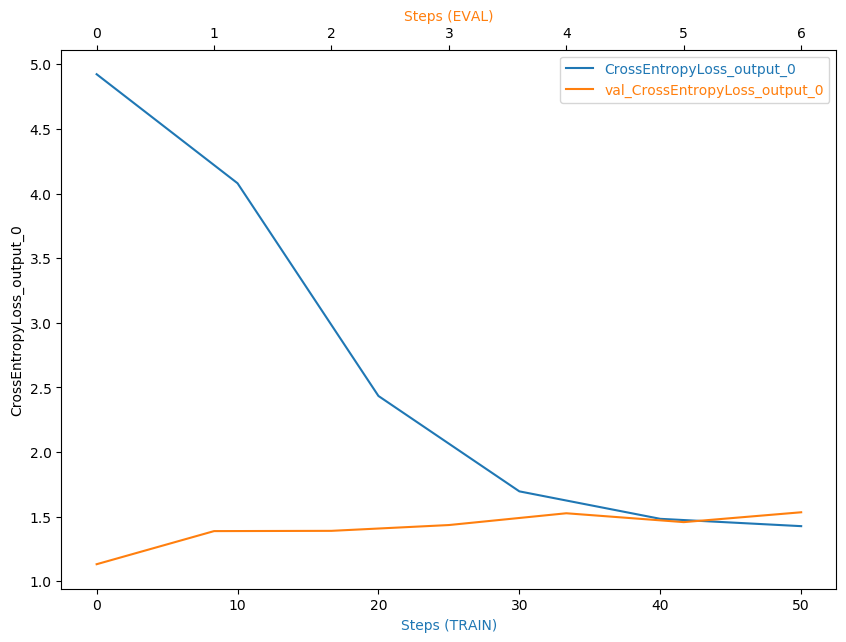

In [38]:
#plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**There is anomalous behaviour of not getting smooth output lines.
* **How would I go about fixing the anomalous behaviour?**
  * Making some adjustments in the pretrained model to use a different set of the fully connected layers network, ideally should help to smoothen out the graph.**
  * If I had more AWS credits, then would have changed the fc layers used in the model. Firstly would try by adding in one more fc layer on top of the existing two layers and check the results, and then if the results didn't improve much then would try by removing all the fc layers and keeping only one fc layer in the model and then rerun the tuning and training jobs and check the outputs

In [39]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [40]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [41]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_repot.zip", "zip", "ProfilerReport")

'/root/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_repot.zip.zip'

## Model Deploying

In [42]:
# TODO: Deploy your model to an endpoint
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

INFO:sagemaker:Creating model with name: pytorch-training-2023-02-21-16-27-55-240
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-02-21-16-27-55-240
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-02-21-16-27-55-240


------!

pytorch-training-2023-02-21-16-27-55-240
Below is the image that we will be testing:


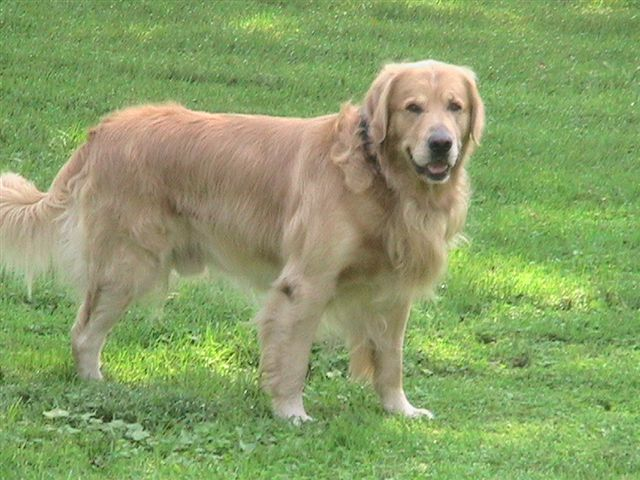

Expected dog breed category no : 76


ReadTimeoutError: Read timeout on endpoint URL: "https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/pytorch-training-2023-02-21-16-27-55-240/invocations"

In [45]:
import os
import io
import boto3
import json
import base64
import PIL
from PIL import Image
import numpy as np
# setting the  environment variables

ENDPOINT_NAME = predictor.endpoint_name
print(ENDPOINT_NAME)
# We will be using the AWS's lightweight runtime solution to invoke an endpoint.
runtime= boto3.client('runtime.sagemaker')
test_dir = "./dogImages/test/"
test_images = ["076.Golden_retriever/Golden_retriever_05258.jpg"]#, '011.Australian_cattle_dog/Australian_cattle_dog_00788.jpg', "129.Tibetan_mastiff/Tibetan_mastiff_08138.jpg"]
test_images_expected_output = [76]#11,129

#for index in range(len(test_images) ):
test_img = test_images[index]
expected_breed_category = test_images_expected_output[index]
    #print(f"Test image no: {index+1}")
test_file_path = os.path.join(test_dir,test_img)
with open(test_file_path , "rb") as f:
    payload = f.read()
    print("Below is the image that we will be testing:")
    display(Image.open(io.BytesIO(payload)))
    print(f"Expected dog breed category no : {expected_breed_category}")
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME, ContentType='image/jpeg',Body=payload)
    response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))        
    print(f"Response: {response_body}")        
    predicted_dog_breed = np.argmax(response_body,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
    print(f"Response/Inference for the above image is : {predicted_dog_breed}")


In [46]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
model_data_artifacts = "s3://sagemaker-us-east-1-532550980733/pytorch-training-230221-1026-004-20536aa1/output/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium") 

INFO:sagemaker:Creating model with name: pytorch-inference-2023-02-21-17-56-39-915
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-02-21-17-56-40-760
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-02-21-17-56-40-760


-----------!

In [47]:
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

In [48]:
trained_model = PyTorchModel(model_data = "s3://sagemaker-us-east-1-532550980733/pytorch-training-230221-1026-004-20536aa1/output/model.tar.gz",
                             role = role,
                             entry_point = 'inference.py',
                             framework_version = '1.8',
                             py_version = 'py36',
                             source_dir = 'code/')

In [49]:
print(predictor.endpoint_name)

pytorch-inference-2023-02-21-17-56-40-760


Test image no: 1
Below is the image that we will be testing:


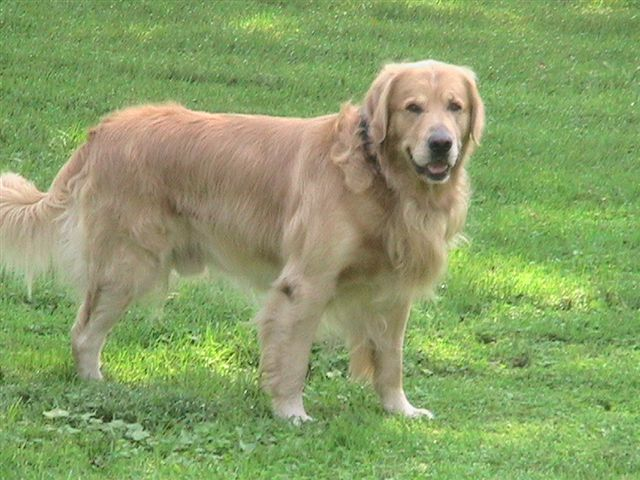

Expected dog breed category no : 76
Response: [[-0.645827    0.20104004 -0.16464049  0.38651606 -0.21806395  0.46734184
  -0.03062405  0.0898333  -0.13827223  0.83622265  0.9508965  -0.01735395
  -0.29018265  0.18540564 -0.06889383  0.11349744  0.11635197  0.51046437
  -0.5005253  -0.04992408  0.54782206  0.07932016  0.16790509 -0.05503724
  -0.2473828   0.35614091  0.29570007  0.46210727 -0.38022599  0.27008307
  -0.21238664 -0.32235792  0.14428993  0.51309764  0.17221266  0.09451108
   0.03641765  0.64430887 -0.50907862 -0.00549512  0.50651067  0.47343487
  -0.25108826 -0.10654429  0.9503985   0.00179823 -0.16464517  0.00772266
  -0.19892786  0.16767557 -0.2811318   0.11289959  0.07898588 -0.16893487
  -0.28418529  0.37791854  0.46922779 -0.35294363 -0.17727749 -0.16421714
   0.01014749 -0.35326293  0.16905963  0.47147757 -0.44627771  0.29762906
  -0.62271994  0.2615276  -0.30864146  0.41577759 -0.14167567 -0.19099359
  -0.09589826 -0.63783717  0.41858172 -0.25959492 -0.03617817 -0.2

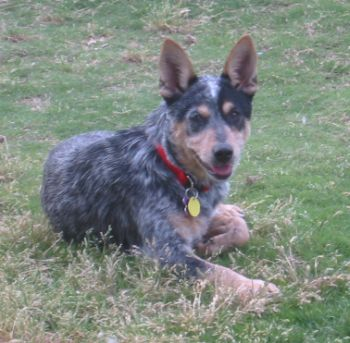

Expected dog breed category no : 11
Response: [[-1.51848868e-01 -4.50494140e-01 -4.00415719e-01  5.95856786e-01
   9.01816413e-02  6.15830123e-01 -2.87832409e-01 -1.44216686e-01
   3.71654667e-02  1.34544566e-01  5.45137465e-01 -1.42386556e-02
  -5.35573840e-01  1.47421390e-01 -8.75684395e-02 -2.60148615e-01
   2.29725614e-02 -8.95070955e-02 -1.17130347e-01  1.65001884e-01
  -1.98035836e-01  2.20022291e-01  1.26399890e-01  1.33342505e-01
  -1.24825194e-01  4.64790255e-01  5.45383096e-01  7.53190100e-01
  -3.97622138e-01 -3.83644760e-01  8.64479914e-02 -6.97476417e-02
   3.52981985e-01  1.52186871e-01  4.33589607e-01  2.65975416e-01
   2.43971154e-01  6.61496818e-01  4.09303606e-01  1.23305053e-01
   4.13627952e-01  4.77836013e-01 -7.22627267e-02  8.47222060e-02
   9.92534518e-01  2.91969091e-01  5.05360723e-01  1.55813415e-02
   1.24886833e-01 -2.16074035e-01 -2.45961666e-01  1.16876625e-01
   3.34002525e-02 -2.73478448e-01 -6.07156932e-01  5.05083427e-02
   6.69444084e-01 -1.41503125e

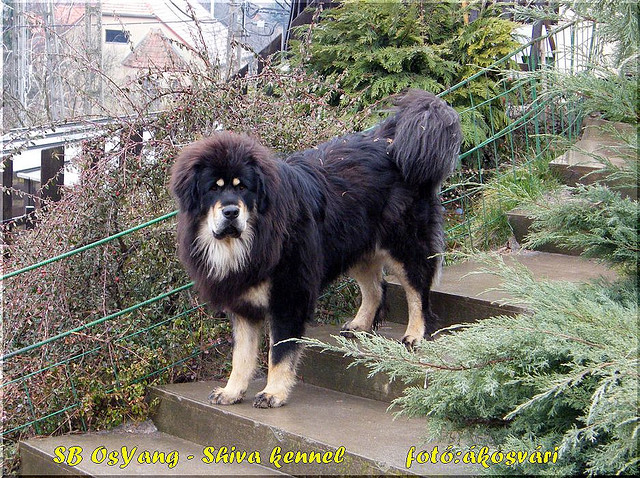

Expected dog breed category no : 129
Response: [[-0.40523225  0.54804385 -0.36533913  0.56922543  0.00543899  0.77768958
   0.01561154 -0.25485694 -0.12529406  0.3686702   0.96352512 -0.03904289
  -0.32005623  0.2633228  -0.30042237  0.09320512 -0.54216278  0.74269348
  -0.06639324 -0.07140993  0.37737891  0.10120216  0.46312746 -0.27615359
  -0.50547081  0.10720857  0.52701914  0.39523962 -0.41695243 -0.08606201
  -0.71778035 -0.51490408  0.33956781  0.63152176 -0.04127669  0.13180859
   0.31755614  0.25572613  0.18155845  0.09440589  0.70075762  0.54623783
  -0.28423554  0.08729326  1.36170292  0.01687411 -0.16199133  0.22857201
  -0.12724683  0.10467756 -0.049235    0.09806368 -0.41844565 -0.41665551
  -0.17144375  0.18682063  0.57875049  0.1208935  -0.49960658 -0.40509516
  -0.41646966 -0.49354082  0.16503204  0.40604135 -0.38404611  0.47807911
  -0.82698709  0.34298036 -0.3870537   0.23019992  0.10871407 -0.6590488
  -0.30394667 -0.71713591  0.27805105 -0.51496232 -0.34604308 -0.5

In [52]:
# Using the runtime boto3 client to test the deployed models endpoint
import os
import io
import boto3
import json
import base64
import PIL

# setting the  environment variables

ENDPOINT_NAME = predictor.endpoint_name
# We will be using the AWS's lightweight runtime solution to invoke an endpoint.
runtime= boto3.client('runtime.sagemaker')
test_dir = "./dogImages/test/"
test_images = ["076.Golden_retriever/Golden_retriever_05258.jpg", '011.Australian_cattle_dog/Australian_cattle_dog_00788.jpg', "129.Tibetan_mastiff/Tibetan_mastiff_08138.jpg"]
test_images_expected_output = [76,11,129]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed category no : {expected_breed_category}")
        response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='image/jpeg',
                                       Body=payload)
        response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))        
        print(f"Response: {response_body}")        
        predicted_dog_breed = np.argmax(response_body,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [64]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2021-12-15-19-47-32-658
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2021-12-15-19-47-32-658
